<a id='toc'></a>
# Initial Processing 
In this notebook, we take a first look at the data, check dimensions, count missing values, clean up some inconsistent values, remove some low variance attributes and delete an attribute that may be corrupt.

1. [Setting up the Environment](#envir)
1. [Read in the Data](#read)
1. [Check Dimensions and Attribute Types for Each Dataframe](#check)
4. [Check Balance of Target Variable](#bal)
5. [Examine Missing Values](#miss)
6. [Checking Data Types](#types)
7. [Checking Summary Statistics, Distributions and Consistency for Numeric Attributes](#num)
    1. [Checking 'app' Dataframe](#appint)
        1. [First check integer type attributes](#appint)
        1. [Now check float type attributes](#appfloat)
    1. [Checking 'bureau' Dataframe](#burint)
        1. [First check integer type attributes](#burint)
        1. [Now check the float type attributes](#burfloat)
    1. [Checking 'bureau_balance' Dataframe](#burbal)
8. [Checking Levels of Categorical Attributes](#cat)
    1. [Checking the dataframe 'app'](#appcat)
    1. [Checking the dataframe 'bureau'](#burcat)
    1. [Checking the dataframe 'bureau_balance'](#balcat)
9. [Outputing the Updated Dataframes for Use in Next Steps](#out)     

<a id='envir'></a>
# 1. Setting up the Environment

[Return](#toc)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import nan as NaN
import os
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 150
pd.options.display.max_columns = 125

In [2]:
# Creates a list of file names in directory
files = os.listdir("C:/Users/X/Documents/A_Documents/Cap_Data/CSV")
print(files)

['application_train.csv', 'app_with_features', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'initial_output', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv']


<a id='read'></a>
# 2. Read in the Data
The main dataframe containing the application data will be 'app'.  
The credit bureau data will be in 'bureau'.  
The credit bureau time sequence data will be in 'bureau_balance'.  

[Return](#toc)

In [35]:
# Read in the files
path = 'C:/Users/X/Documents/A_Documents/Cap_Data/CSV/'
app = pd.read_csv(path + 'application_train.csv')
bureau = pd.read_csv(path + 'bureau.csv')
bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
prev_app = pd.read_csv(path + 'previous_application.csv')
pos_cash_bal = pd.read_csv(path + 'pos_cash_balance.csv')
instal_pay = pd.read_csv(path + 'installments_payments.csv')
credit_card_bal = pd.read_csv(path + 'credit_card_balance.csv')

# A list of lists to hold dataframes and their names for looping below
dfs = [[app, 'app'], [bureau, 'bureau'], [bureau_balance, 'bureau_balance'], [prev_app, 'prev_app'], [pos_cash_bal, 'pos_cash_bal'], [instal_pay, 'instal_pay'], [credit_card_bal, 'credit_card_bal']]


<a id='check'></a>
# 3. Check Dimensions and Attribute Types for Each Dataframe

[Return](#toc)

In [4]:
# Count the columns, rows, numeric and catorgorical attributes

# Set up empty dataframe to hold values
info_table = pd.DataFrame(index = ['Attributes', 'Observations', 'Categorical', 'Numeric'])

# loop through all dataframes and populate the info_table with values
for pair in dfs:
    rows = pair[0].shape[0]
    cols = pair[0].shape[1]
    cat = sum(pair[0].dtypes == 'object')
    num = sum(pair[0].dtypes != 'object')
    info_table[pair[1]] = [cols, rows, cat, num]

info_table

# info_table.to_html('table.html')

,app,bureau,bureau_balance,prev_app,pos_cash_bal,instal_pay,credit_card_bal
Attributes,122,17,3,37,8,8,23
Observations,307511,1716428,27299925,1670214,10001358,13605401,3840312
Categorical,16,3,1,16,1,0,1
Numeric,106,14,2,21,7,8,22


<a id='bal'></a>
# 4. Check Balance of Target Variable
We have a very imbalanced target variable. This will need addressing when the prediction experiment is setup.

[Return](#toc)

In [5]:
# Check the balance of the TARGET variable
# print(app['TARGET'].value_counts(dropna=False))
pd.DataFrame({'Count':app['TARGET'].value_counts(), \
'Percent (%)':round(app['TARGET'].value_counts()/len(app)*100,1)})

,Count,Percent (%)
0,282686,91.9
1,24825,8.1


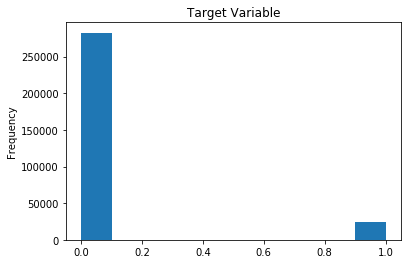

In [6]:
# Output a histogram to png file
app['TARGET'].plot.hist(title = 'Target Variable');
# plt.savefig('target_hist.png', bbox_inches='tight')
# plt.close()

<a id='miss'></a>
# 5. Examine Missing Values
Here we are checking the missing values counts for all dataframes. Removing or imputing missing values will be addressed later.

[Return](#toc)

In [7]:
# Count attributes and observations with missing values

def missing_values(df, name, p, q):
    """ 
    Function to calculate number of missing values in attributes and observations.
    df: dataframe
    names: name of dataframe
    p: theshold used to calculate number of attributes with missing values > p%
    q: theshold used to calculate number of observations with missing values > q%
    """
    # Set up empty dataframe to hold results
    results = pd.DataFrame(index = ['Attributes', 'Attributes with Missing Values', 'Attributes with Missing Values > '+str(p)+'%', \
                                   'Observations', 'Observations with Missing Values', 'Observations with Missing Values > '+str(q)+'%'])
    
    # Number of columns
    cols = df.shape[1]
    # Calculate number of missing values in each column
    no_mis_val_in_col = df.isnull().sum()  #sum() acts on cols in dataframe -> defaults to sum(axis=0)
    #Count number of cols with missing values
    no_col_with_mis_val = sum(no_mis_val_in_col != 0)
    # Calculate % of missing values in each column
    percent_mis_val_in_col = round(no_mis_val_in_col / len(df) * 100, 1) 
    # Calculate number of cols with missing values > p%
    no_cols_greater_p = sum(percent_mis_val_in_col > p)
    
    # Number of rows
    rows = len(df)
    # Calculate number of missing values in each row
    no_mis_val_in_row = df.isnull().sum(axis = 1)
    # Count number of rows with missing values
    no_rows_with_mis_val = np.count_nonzero(no_mis_val_in_row)
    # Calculate % of missing values in each row
    percent_mis_val_in_row = round(no_mis_val_in_row / cols * 100, 1)
    # Calculate number of rows with missing values > q%
    no_rows_greater_p = np.count_nonzero(percent_mis_val_in_row > q)
    
    
    results[name] = [cols, no_col_with_mis_val, no_cols_greater_p, rows, no_rows_with_mis_val, no_rows_greater_p]
    return results

hold = pd.DataFrame()
i = 1
p = 60
q = 50
for pair in dfs:
    if i == 1:
        hold = missing_values(pair[0], pair[1], p, q)
    else: 
        hold = pd.merge(hold, missing_values(pair[0], pair[1], p, q), left_index=True, right_index=True)
    i += 1
hold

,app,bureau,bureau_balance,prev_app,pos_cash_bal,instal_pay,credit_card_bal
Attributes,122,17,3,37,8,8,23
Attributes with Missing Values,67,7,0,16,2,2,9
Attributes with Missing Values > 60%,17,2,0,2,0,0,0
Observations,307511,1716428,27299925,1670214,10001358,13605401,3840312
Observations with Missing Values,298909,1676762,0,1670143,26184,2905,826036
Observations with Missing Values > 50%,0,0,0,0,0,0,0


For our initial three dataframes of interest ('app', 'bureau' and 'bureau_balance'), let's check the missing values by attribute.

In [8]:
# Function to show number and percentage of missing missing values (above p%) by column name
def att_missing_values(df, p):
    #Calculate number of missing values in each column
    no_mis_val_in_col = df.isnull().sum()
    #Calculate percentage of missing values in each column
    percent_mis_val_in_col = round(no_mis_val_in_col / len(df) * 100, 1)
    #Put results in a dataframe
    results = pd.DataFrame({'Number':no_mis_val_in_col, "Percent (%)":percent_mis_val_in_col}, index = df.columns)
    # Filter out attributes with missing values below p%
    results = results[results['Percent (%)']>p]
    return results

p=60
print("app Attributes with Missing Values > "+str(p)+"%\n")
print(att_missing_values(app, p).sort_values(by='Percent (%)', ascending=False))
print("\nbureau Attributes with Missing Values > "+str(p)+"%\n")
print(att_missing_values(bureau, p).sort_values(by='Percent (%)', ascending=False))
print("\nbureau_balance Attributes with Missing Values > "+str(p)+"%")
print(att_missing_values(bureau_balance, p).sort_values(by='Percent (%)', ascending=False))

app Attributes with Missing Values > 60%

                          Number  Percent (%)
COMMONAREA_MEDI           214865         69.9
COMMONAREA_AVG            214865         69.9
COMMONAREA_MODE           214865         69.9
NONLIVINGAPARTMENTS_MEDI  213514         69.4
NONLIVINGAPARTMENTS_AVG   213514         69.4
NONLIVINGAPARTMENTS_MODE  213514         69.4
FONDKAPREMONT_MODE        210295         68.4
LIVINGAPARTMENTS_AVG      210199         68.4
LIVINGAPARTMENTS_MEDI     210199         68.4
LIVINGAPARTMENTS_MODE     210199         68.4
FLOORSMIN_MEDI            208642         67.8
FLOORSMIN_MODE            208642         67.8
FLOORSMIN_AVG             208642         67.8
YEARS_BUILD_MEDI          204488         66.5
YEARS_BUILD_AVG           204488         66.5
YEARS_BUILD_MODE          204488         66.5
OWN_CAR_AGE               202929         66.0

bureau Attributes with Missing Values > 60%

                         Number  Percent (%)
AMT_ANNUITY             1226791        

There is only one attribute with missing values above 70%. We will not remove any attributes at this time.

<a id='types'></a>
# 6. Checking Data Types
Check the data types for attributes in the initial three dataframes of interest ('app', 'bureau' and 'bureau_balance').

All data types look fine.

[Return](#toc)

In [9]:
# Checking the data types of attributes of app, bureau & bureau_balance
print("app Data Types\n"); print(app.dtypes); print('\n')
print("bureau Data Types\n"); print(bureau.dtypes); print('\n')
print("bureau_balance Data Types\n"); print(bureau_balance.dtypes); print('\n')

app Data Types

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE         

<a id='num'></a>
# 7. Checking Summary Statistics, Distributions and Consistency for Numeric Attributes

[Return](#toc)

<a id='appint'></a>
## A. Checking 'app' Dataframe  
### (a) First check integer type attributes

[Return](#toc)

In [10]:
# Selecting all columns with data type int64
app.select_dtypes('int64').describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0000

### CNT_CHILDREN
The maximum value of CNT_CHILDREN looks too high at 19. We need to check the full distribution and frequency table.  

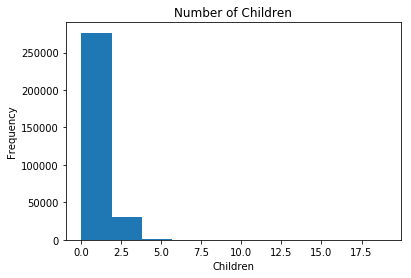

In [11]:
# Plot the distribution of CNT_CHILDREN
app['CNT_CHILDREN'].plot.hist(title = 'Number of Children')
plt.xlabel('Children');

In [12]:
# Look at the frequency table of CNT_CHILDREN
app['CNT_CHILDREN'].value_counts().sort_index()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
8          2
9          2
10         2
11         1
12         2
14         3
19         2
Name: CNT_CHILDREN, dtype: int64

The number of potential high 'outliers' is very low. We will leave 'as is' for now.

### DAYS_EMPLOYED
DAYS_EMPLOYED has a 1000 year positive value while the other values are negative. We need to check this.

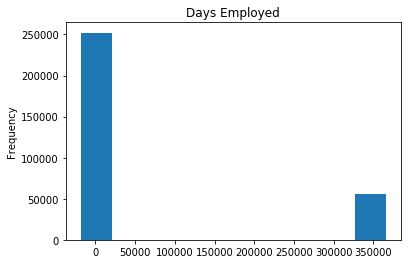

In [13]:
app['DAYS_EMPLOYED'].plot.hist(title = 'Days Employed');

Quite a large number of observations have this inconsistent value.

In [27]:
# How many observations have this inconsistent value?
sum(app['DAYS_EMPLOYED'] == 365243)

55374

We will replace this value with NaN and create a boolean flag attribute to mark the change.

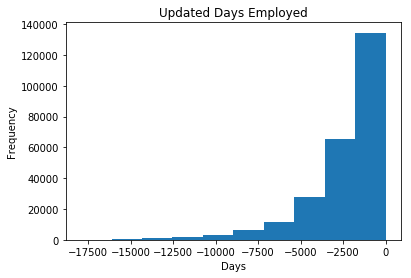

In [15]:
# Create the flag attribute
app['DAYS_EMPLOYED_FLAG'] = (app["DAYS_EMPLOYED"] == 365243)
# Replace 365243 with NaN
app['DAYS_EMPLOYED'].replace({365243: NaN}, inplace = True)
# Replot the histogram
app['DAYS_EMPLOYED'].plot.hist(title = 'Updated Days Employed')
plt.xlabel('Days');

The new distribution looks much more like what we'd expect to see.

### FLAG_MOBIL and FLAG_CONT_MOBILE
Both these attributes have very low variance. See the frequency tables below. We will remove these attributes.

In [16]:
# Checking frequency tables
print('Frequency Table Shown as Percentage\n')
print(app['FLAG_MOBIL'].value_counts(dropna=False)/len(app)); print('\n')
print(app['FLAG_CONT_MOBILE'].value_counts(dropna=False)/len(app))

Frequency Table Shown as Percentage

1    0.999997
0    0.000003
Name: FLAG_MOBIL, dtype: float64


1    0.998133
0    0.001867
Name: FLAG_CONT_MOBILE, dtype: float64


In [17]:
# Removing the attributes
app.drop(['FLAG_MOBIL', 'FLAG_CONT_MOBILE'], axis=1, inplace=True)

### REG_REGION_NOT_LIVE_REGION and LIVE_REGION_NOT_WORK_REGION
Both these attributes have very low variance. See the frequency tables below. We will remove these attributes.

In [18]:
# Checking frequency tables
print('Frequency Table Shown as Percentage\n')
print(app['REG_REGION_NOT_LIVE_REGION'].value_counts(dropna=False)/len(app)); print('\n')
print(app['LIVE_REGION_NOT_WORK_REGION'].value_counts(dropna=False)/len(app))

Frequency Table Shown as Percentage

0    0.984856
1    0.015144
Name: REG_REGION_NOT_LIVE_REGION, dtype: float64


0    0.959341
1    0.040659
Name: LIVE_REGION_NOT_WORK_REGION, dtype: float64


In [19]:
# Removing the attributes
app.drop(['REG_REGION_NOT_LIVE_REGION', 'LIVE_REGION_NOT_WORK_REGION'], axis=1, inplace=True)

### FLAG_DOCUMENT_2, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 & 21
All the above attributes have close to zero variance. They will be removed. FLAG_DOCUMENT_3, 6 & 8 will remain.

In [20]:
# Example of low variance FLAG_DOCUMENT_ attribute.
print('Frequency Table shown as Percentage\n')
print(round(app['FLAG_DOCUMENT_13'].value_counts(dropna=False)\
            .sort_index()/len(app),5)*100)

Frequency Table shown as Percentage

0    99.647
1     0.353
Name: FLAG_DOCUMENT_13, dtype: float64


In [21]:
# Removing the attributes
app.drop(['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5',\
          'FLAG_DOCUMENT_7','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10',\
          'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',\
          'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',\
          'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',\
          'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21'], axis=1, inplace=True)

<a id='appfloat'></a>
### (b) Now check float type attributes 

[Return](#toc)

In [22]:
# Selecting all columns with data type float64
app.select_dtypes('float').describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,252137.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-2384.169325,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.977752,0.755746,0.044595,0.078078,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,2338.360162,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,0.161380,0.081184,0.092576,0.110565,0.047732,0.069523,0.107936,0.084307,0.064575,0.110111,0.074445,0.132256,0.100977,0.143709,0.161160,0.081750,0.097880,0.111845,0.046276,0.070254,0.109076,0.082179,0.059897,0.112066,0.076144,0.134467,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-17912.000000,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,0.000527,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.0000

### AMT_INCOME_TOTAL
The distribution has a small number of large 'outliers' above 1,000,000 but with one potentially spurious value above 100,000,000. The spurious value will be set to NaN.

Number of observations above 100,000,000 is: 1
Number of observations above 1,000,000 is: 250
Percentage of observations above 1,000,000 is: 0.08%


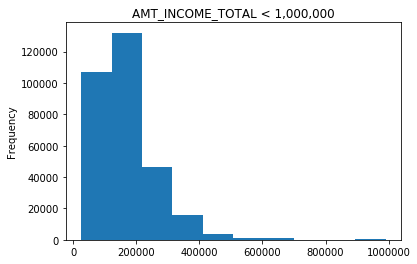

In [25]:
print('Number of observations above 100,000,000 is: '+str(sum(app['AMT_INCOME_TOTAL']>100000000)))
print('Number of observations above 1,000,000 is: '+str(sum(app['AMT_INCOME_TOTAL']>1000000)))
print('Percentage of observations above 1,000,000 is: {:.2f}%'.format(sum(app['AMT_INCOME_TOTAL']>1000000)/len(app)*100))
app.loc[app['AMT_INCOME_TOTAL']<1000000, 'AMT_INCOME_TOTAL'].plot.hist(title='AMT_INCOME_TOTAL < 1,000,000');

In [24]:
# Setting the spurious value to NaN
app.loc[app['AMT_INCOME_TOTAL']>100000000, 'AMT_INCOME_TOTAL'] = NaN

### OWN_CAR_AGE
The unit of measurement is not clear (perhaps months?) and the maximum value looks high. We should check the full distribution.

Percentage of observations over 60: 1.1%


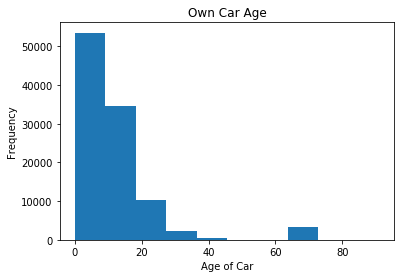

In [25]:
app['OWN_CAR_AGE'].plot.hist(title = 'Own Car Age')
plt.xlabel('Age of Car')
print('Percentage of observations over 60: {}%'.format(round(100*sum(app['OWN_CAR_AGE']>60)/len(app),1)))

The number of high 'outliers' is small. We will leave 'as is' for now.

### XX_CNT_SOCIAL_CIRCLE
Let's check the frequency tables for the four attributes. The maximum values look potentially high.

In [26]:
# Check frequency tables
print("OBS_30_CNT_SOCIAL_CIRCLE"); print(app['OBS_30_CNT_SOCIAL_CIRCLE'].value_counts().sort_index())
print("\nOBS_60_CNT_SOCIAL_CIRCLE");print(app['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index())
print("\nDEF_30_CNT_SOCIAL_CIRCLE");print(app['DEF_30_CNT_SOCIAL_CIRCLE'].value_counts().sort_index())
print("\nDEF_60_CNT_SOCIAL_CIRCLE");print(app['DEF_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index())

OBS_30_CNT_SOCIAL_CIRCLE
0.0      163910
1.0       48783
2.0       29808
3.0       20322
4.0       14143
5.0        9553
6.0        6453
7.0        4390
8.0        2967
9.0        2003
10.0       1376
11.0        852
12.0        652
13.0        411
14.0        258
15.0        166
16.0        133
17.0         88
18.0         46
19.0         44
20.0         30
21.0         29
22.0         22
23.0         15
24.0         11
25.0         11
26.0          3
27.0          5
28.0          1
29.0          1
30.0          2
47.0          1
348.0         1
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: int64

OBS_60_CNT_SOCIAL_CIRCLE
0.0      164666
1.0       48870
2.0       29766
3.0       20215
4.0       13946
5.0        9463
6.0        6349
7.0        4344
8.0        2886
9.0        1959
10.0       1335
11.0        837
12.0        620
13.0        401
14.0        238
15.0        166
16.0        137
17.0         73
18.0         49
19.0         44
20.0         30
21.0         28
22.0         20
23.0    

Are all these high values from the same observation?

In [27]:
# Checking to see if one observation has all values
app[app['OBS_30_CNT_SOCIAL_CIRCLE']==348][['OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE', \
                                           'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']]

,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
148403,348.0,344.0,34.0,24.0


Yes, they all come from the same observation. Let's set these values to NaN; they will be imputed later.

In [28]:
# Setting the spurious values to NaN
app.loc[148403,['OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE', \
                                           'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']] = NaN
app.loc[148403,['OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE', \
                                           'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']]

OBS_30_CNT_SOCIAL_CIRCLE    NaN
OBS_60_CNT_SOCIAL_CIRCLE    NaN
DEF_30_CNT_SOCIAL_CIRCLE    NaN
DEF_60_CNT_SOCIAL_CIRCLE    NaN
Name: 148403, dtype: object

### AMT_REQ_CREDIT_BUREAU_XXX
AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY and AMT_REQ_CREDIT_BUREAU_WEEK all have low variances. See all frequency tables below.

These three attributes will be removed.

In [29]:
# Printing the frequency tables
print('Frequency Tables Shown in Percentage\n')
print('AMT_REQ_CREDIT_BUREAU_HOUR'); print(app['AMT_REQ_CREDIT_BUREAU_HOUR'].value_counts(dropna=False)/len(app))
print('\nAMT_REQ_CREDIT_BUREAU_DAY'); print(app['AMT_REQ_CREDIT_BUREAU_DAY'].value_counts(dropna=False)/len(app))
print('\nAMT_REQ_CREDIT_BUREAU_WEEK'); print(app['AMT_REQ_CREDIT_BUREAU_WEEK'].value_counts(dropna=False)/len(app))
print('\nAMT_REQ_CREDIT_BUREAU_MON'); print(app['AMT_REQ_CREDIT_BUREAU_MON'].value_counts(dropna=False)/len(app))
print('\nAMT_REQ_CREDIT_BUREAU_QRT'); print(app['AMT_REQ_CREDIT_BUREAU_QRT'].value_counts(dropna=False)/len(app))
print('\nAMT_REQ_CREDIT_BUREAU_YEAR'); print(app['AMT_REQ_CREDIT_BUREAU_YEAR'].value_counts(dropna=False)/len(app))

Frequency Tables Shown in Percentage

AMT_REQ_CREDIT_BUREAU_HOUR
 0.0    0.859696
NaN     0.135016
 1.0    0.005073
 2.0    0.000182
 3.0    0.000029
 4.0    0.000003
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: float64

AMT_REQ_CREDIT_BUREAU_DAY
 0.0    0.860142
NaN     0.135016
 1.0    0.004201
 2.0    0.000345
 3.0    0.000146
 4.0    0.000085
 5.0    0.000029
 6.0    0.000026
 9.0    0.000007
 8.0    0.000003
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64

AMT_REQ_CREDIT_BUREAU_WEEK
 0.0    0.837225
NaN     0.135016
 1.0    0.026692
 2.0    0.000647
 3.0    0.000189
 4.0    0.000111
 6.0    0.000065
 5.0    0.000033
 8.0    0.000016
 7.0    0.000007
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64

AMT_REQ_CREDIT_BUREAU_MON
 0.0     0.722683
NaN      0.135016
 1.0     0.107791
 2.0     0.017515
 3.0     0.006475
 4.0     0.003499
 5.0     0.001958
 6.0     0.001115
 7.0     0.000969
 9.0     0.000670
 8.0     0.000602
 10.0    0.000429
 11.0    0.000387
 12.0    0.000250
 13.0    0.00

In [30]:
# Removing the attributes
app.drop(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', \
          'AMT_REQ_CREDIT_BUREAU_WEEK'], axis=1, inplace=True)

The maximum value for AMT_REQ_CREDIT_BUREAU_QRT looks spuriuos. Let's replace with NaN. It will be imputed later.

In [31]:
# Replacing the spurious value with NaN
app.loc[app['AMT_REQ_CREDIT_BUREAU_QRT'] == 261,['AMT_REQ_CREDIT_BUREAU_QRT']] = NaN

<a id='burint'></a>
## B. Checking 'bureau' Dataframe  
### (a) First check integer type attributes

[Return](#toc)

In [32]:
# Selecting all columns with data type int64
bureau.select_dtypes('int64').describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,DAYS_CREDIT_UPDATE
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,6.410406e-03,-5.937483e+02
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,9.622391e-02,7.207473e+02
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,0.000000e+00,-4.194700e+04
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,0.000000e+00,-9.080000e+02
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,0.000000e+00,-3.950000e+02
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,0.000000e+00,-3.300000e+01
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,9.000000e+00,3.720000e+02


### DAYS_CREDIT
Distribution looks ok.

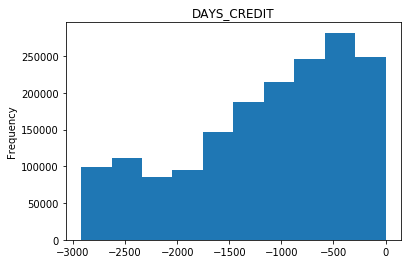

In [33]:
bureau['DAYS_CREDIT'].plot.hist(title = 'DAYS_CREDIT');

### CREDIT_DAY_OVERDUE and CNT_CREDIT_PROLONG
Over 99% of the values for these attributes are 0. These attributes will be removed.

In [34]:
# Checking the 'low end' of the frequency tables - examining percentages
print('CREDIT_DAY_OVERDUE'); print(bureau[bureau['CREDIT_DAY_OVERDUE']<10]['CREDIT_DAY_OVERDUE'].value_counts(dropna=False)/len(bureau)*100)
print('\nCNT_CREDIT_PROLONG'); print(bureau[bureau['CNT_CREDIT_PROLONG']<10]['CNT_CREDIT_PROLONG'].value_counts(dropna=False)/len(bureau)*100)

CREDIT_DAY_OVERDUE
0    99.754315
8     0.006001
9     0.005418
7     0.005360
6     0.003437
5     0.002971
4     0.002680
3     0.001690
2     0.001049
1     0.000291
Name: CREDIT_DAY_OVERDUE, dtype: float64

CNT_CREDIT_PROLONG
0    99.469014
1     0.443945
2     0.071194
3     0.011128
4     0.003146
5     0.001223
9     0.000117
6     0.000117
8     0.000058
7     0.000058
Name: CNT_CREDIT_PROLONG, dtype: float64


In [35]:
# Removing the attributes
bureau.drop(['CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG'], axis = 1, inplace=True)

### DAYS_CREDIT_UPDATE
This attribute has inconsistent positive values and a very large (in absolute terms) minimum value representing 115 years.

Lets check the distribution of "reasonable" values between 0 and -3000.

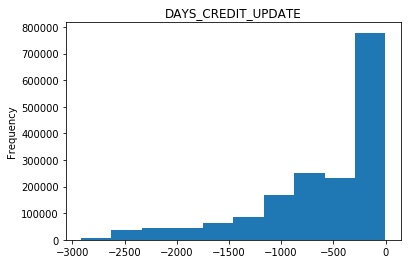

In [36]:
# Looking at the distribution of values between 0 and -3000 (about 8 years)
bureau[(bureau['DAYS_CREDIT_UPDATE']<0) & (bureau['DAYS_CREDIT_UPDATE']>-3000)]['DAYS_CREDIT_UPDATE'].plot.hist(title='DAYS_CREDIT_UPDATE');

The distribution of between 0 and -3000 (about 8 years) looks ok. Let's check the 'outliers' below -3000 and above 0.

In [37]:
# Number of observations with DAYS_CREDIT_UPDATE below -3000 (about 8 years) and above 0
print("{} observations below -3000 (about 8 years)".format(sum(bureau['DAYS_CREDIT_UPDATE']<-3000)))
print("{} observations above 0".format(sum(bureau['DAYS_CREDIT_UPDATE']>0)))

95 observations below -3000 (about 8 years)
17 observations above 0


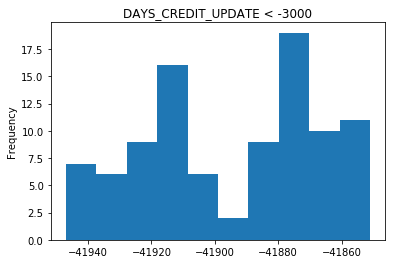

In [38]:
# Distribution below -3000
bureau[bureau['DAYS_CREDIT_UPDATE']<-3000]['DAYS_CREDIT_UPDATE'].plot.hist(title='DAYS_CREDIT_UPDATE < -3000');

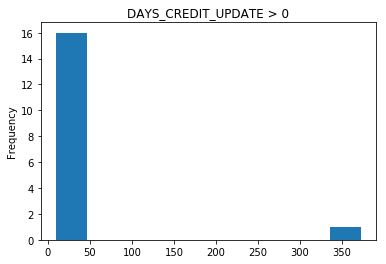

In [39]:
# Distribution above zero
bureau[bureau['DAYS_CREDIT_UPDATE']>0]['DAYS_CREDIT_UPDATE'].plot.hist(title='DAYS_CREDIT_UPDATE > 0');

The values below -3000 and above 0 look spurious. We will replace these values with NaN.

In [40]:
# Replacing spurious values with NaN
bureau.loc[bureau['DAYS_CREDIT_UPDATE'] < -3000, ['DAYS_CREDIT_UPDATE']] = NaN
bureau.loc[bureau['DAYS_CREDIT_UPDATE'] > 0, ['DAYS_CREDIT_UPDATE']] = NaN

<a id='burfloat'></a>
### (b) Now check the float type attributes

[Return](#toc)

In [41]:
# Selecting all columns with data type float
bureau.select_dtypes('float').describe()

,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.610875e+06,1.082775e+06,5.919400e+05,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716316e+06,4.896370e+05
mean,5.105174e+02,-1.017437e+03,3.825418e+03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.914685e+02,1.571276e+04
std,4.994220e+03,7.140106e+02,2.060316e+05,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,6.519864e+02,3.258269e+05
min,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-2.917000e+03,0.000000e+00
25%,-1.138000e+03,-1.489000e+03,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,-3.300000e+02,-8.970000e+02,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,4.740000e+02,-4.250000e+02,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,3.119900e+04,0.000000e+00,1.159872e+08,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,0.000000e+00,1.184534e+08


### DAYS_CREDIT_ENDDATE
This attribute has inconsistent positive values and a very large (in absolute terms) minimum value representing 115 years.

In [42]:
# Count the positive values
print("Number of positive values: {}".format(sum(bureau['DAYS_CREDIT_ENDDATE']>0)))
print("Percenatge of positive values: {}%".format(round(sum(bureau['DAYS_CREDIT_ENDDATE']>0)/len(bureau)*100,1)))

Number of positive values: 602603
Percenatge of positive values: 35.1%


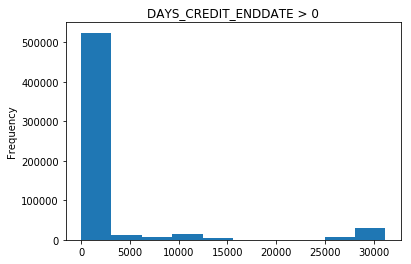

In [43]:
# Distribution of positive values
bureau[bureau['DAYS_CREDIT_ENDDATE']>0]['DAYS_CREDIT_ENDDATE']\
.plot.hist(title = 'DAYS_CREDIT_ENDDATE > 0');

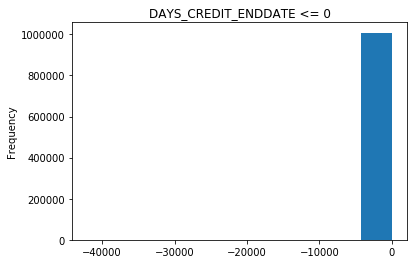

In [44]:
# Distribution of negative values
bureau[bureau['DAYS_CREDIT_ENDDATE']<=0]['DAYS_CREDIT_ENDDATE']\
.plot.hist(title = 'DAYS_CREDIT_ENDDATE <= 0');

This attribute may be corrupted given the large number of inconsistent positive values. We will remove this attribute.

In [45]:
# Removing the attribute
bureau.drop('DAYS_CREDIT_ENDDATE', axis = 1, inplace=True)

### DAYS_ENDDATE_FACT
There are no inconsistent values but a very large (in absolute terms) minimum value representing 115 years. Let's look at the distribution.

Distribution with extreme value.



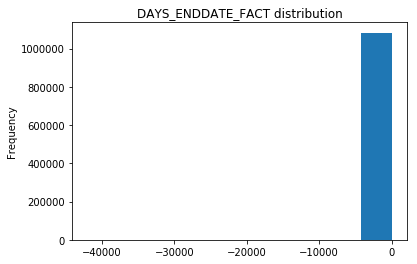

In [41]:
print('Distribution with extreme value.\n')
bureau['DAYS_ENDDATE_FACT'].plot.hist(title='DAYS_ENDDATE_FACT distribution');

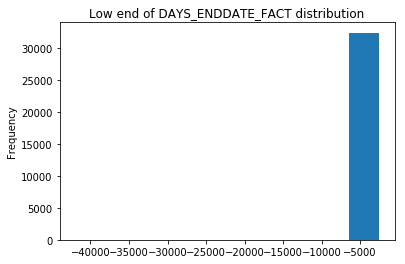

In [38]:
bureau[(bureau['DAYS_ENDDATE_FACT']<-2500) & (bureau['DAYS_ENDDATE_FACT']>-50000)]['DAYS_ENDDATE_FACT']\
.plot.hist(title='Low end of DAYS_ENDDATE_FACT distribution');

There appears to be one spurious observations. Let's replace the observation with NaN.

In [39]:
# Checking the low end of the frequency table
print('Frequency count of observations below -3000:')
bureau[(bureau['DAYS_ENDDATE_FACT']<-3000) & (bureau['DAYS_ENDDATE_FACT']>-50000)]['DAYS_ENDDATE_FACT'].value_counts()

Frequency count of observations below -3000:


-3042.0     1
-42023.0    1
Name: DAYS_ENDDATE_FACT, dtype: int64

The distribution looks better with the extreme value removed.



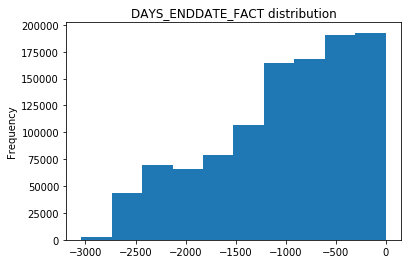

In [42]:
# Replacing the observation with NaN
bureau.loc[bureau['DAYS_ENDDATE_FACT'] == -42023, ['DAYS_ENDDATE_FACT']] = NaN
print('The distribution looks better with the extreme value removed.\n')
bureau['DAYS_ENDDATE_FACT'].plot.hist(title='DAYS_ENDDATE_FACT distribution');

### AMT_CREDIT_MAX_OVERDUE
There are no inconsistent values but a low number of high 'outlier' values. We will leave 'as is'.

The number of observations above 100,000 is:1503


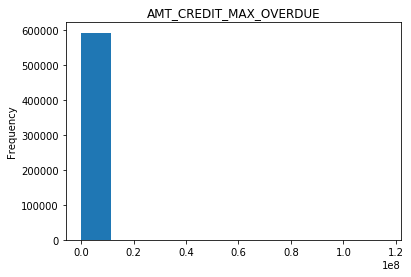

In [49]:
print('The number of observations above 100,000 is:' +str(sum(bureau['AMT_CREDIT_MAX_OVERDUE']>100000)))
bureau['AMT_CREDIT_MAX_OVERDUE'].plot.hist(title ='AMT_CREDIT_MAX_OVERDUE');

#data = bureau[bureau['AMT_CREDIT_MAX_OVERDUE']>100000]['AMT_CREDIT_MAX_OVERDUE']
#data.plot.hist(title='AMT_CREDIT_MAX_OVERDUE > 100,000');

### AMT_CREDIT_SUM
There are no inconsistent values but a low number of high 'outlier' values. We will leave 'as is'.

The number of observations above 10,000,000 is:2183


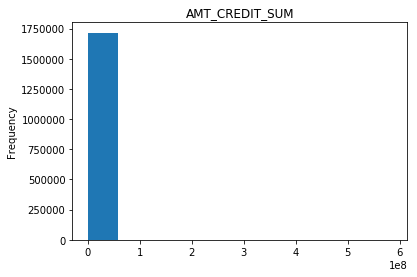

In [50]:
print('The number of observations above 10,000,000 is:' +str(sum(bureau['AMT_CREDIT_SUM']>10000000)))
bureau['AMT_CREDIT_SUM'].plot.hist(title ='AMT_CREDIT_SUM');

### AMT_CREDIT_SUM_DEBT
There are negative values which seems inconsistent with the definition of 'amount of debt'. Let's examine the negative values.

In [51]:
# Looking at the negative values
print(bureau[bureau['AMT_CREDIT_SUM_DEBT']<0]['AMT_CREDIT_SUM_DEBT'].describe())
print('\nThe percentage of negative values is {}%'.format(round(sum(bureau['AMT_CREDIT_SUM_DEBT']<0)/len(bureau)*100,1)))

count    8.418000e+03
mean    -7.810927e+03
std      9.690395e+04
min     -4.705600e+06
25%     -4.920300e+02
50%     -1.982925e+02
75%     -4.550625e+01
max     -4.500000e-02
Name: AMT_CREDIT_SUM_DEBT, dtype: float64

The percentage of negative values is 0.5%


The amount of negative values is small. We will set these observations to NaN. 

In [52]:
# Setting the observations to NaN
bureau.loc[bureau['AMT_CREDIT_SUM_DEBT'] <0, ['AMT_CREDIT_SUM_DEBT']] = NaN

Let's check the distribution of the remaining positive values.

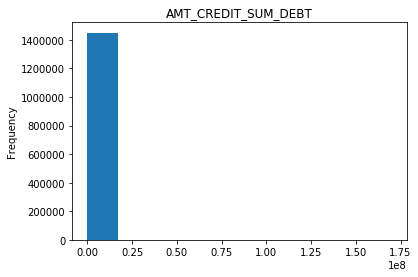

In [53]:
bureau['AMT_CREDIT_SUM_DEBT'].plot.hist(title='AMT_CREDIT_SUM_DEBT');

Let's check the high end of the distribution

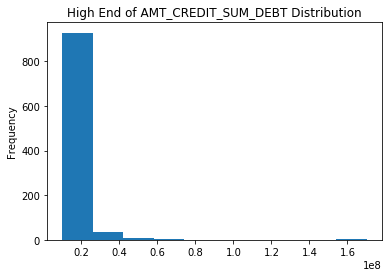

In [54]:
# Plotting the high end of the distribution
bureau[bureau['AMT_CREDIT_SUM_DEBT']>10000000]['AMT_CREDIT_SUM_DEBT'].plot.hist(title='High End of AMT_CREDIT_SUM_DEBT Distribution');

There is a low number of high values. We will leave 'as is' for now.

### AMT_CREDIT_SUM_LIMIT
There is a small number of negative values that seem spurious given this attributes represents a credit limit. These observations will be set to NaN.

In [55]:
# Looking at the negative values
bureau[bureau['AMT_CREDIT_SUM_LIMIT']<0]['AMT_CREDIT_SUM_LIMIT'].describe()

count       351.000000
mean     -23759.679744
std       62744.391989
min     -586406.115000
25%      -11656.845000
50%       -4491.180000
75%       -1495.395000
max          -0.135000
Name: AMT_CREDIT_SUM_LIMIT, dtype: float64

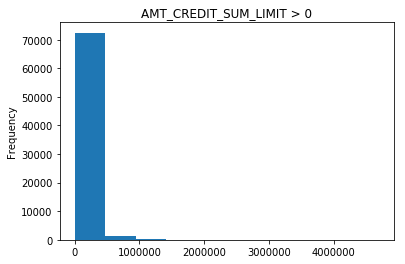

In [56]:
# Distribution of the positive values
bureau[bureau['AMT_CREDIT_SUM_LIMIT']>0]['AMT_CREDIT_SUM_LIMIT'].plot.hist(title = 'AMT_CREDIT_SUM_LIMIT > 0');

In [57]:
# Setting the observations to NaN
bureau.loc[bureau['AMT_CREDIT_SUM_LIMIT'] <0, ['AMT_CREDIT_SUM_LIMIT']] = NaN

### AMT_CREDIT_SUM_OVERDUE
Over 99% of values are zero. We will drop this attribute.

In [58]:
print("{}% of observations equal to 0".format(round(sum(bureau['AMT_CREDIT_SUM_OVERDUE']==0) \
                                                    /len(bureau),3) * 100))


99.8% of observations equal to 0


In [59]:
# Dropping the attribute
bureau.drop('AMT_CREDIT_SUM_OVERDUE', axis = 1, inplace = True)

### AMT_ANNUITY
Recall that AMT_ANNUITY has a large number of missing values (about 72%). Of the non-missing values, over 52% are zero. This attribute should represent the regular repayment amount so zero values are essentailly missing values. Given the large number of missing values, we will remove this attribute.

In [60]:
#Percentage of zero values
print('{}% of non-NaN values equal to 0'.format(round(sum(bureau['AMT_ANNUITY']==0)/sum(bureau['AMT_ANNUITY'].notnull()) * 100,1)))

52.5% of non-NaN values equal to 0


In [61]:
# Dropping the attribute
bureau.drop('AMT_ANNUITY', axis = 1, inplace = True)

<a id='burbal'></a>
## C. Checking 'bureau_balance' Dataframe  

[Return](#toc)

In [62]:
# Summary statistics
bureau_balance.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


### MONTHS_BALANCE
This is a time stamp in months before application. There appears to be no inconsistent values and the distribution looks as expected.

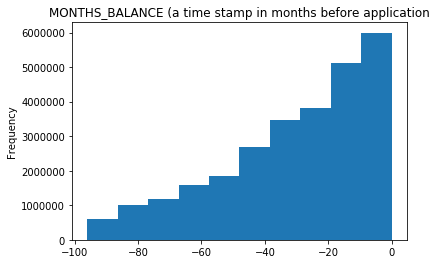

In [63]:
# Plot the histogram
bureau_balance['MONTHS_BALANCE'].plot.hist(title = 'MONTHS_BALANCE (a time stamp in months before application');

<a id='cat'></a>
# 8. Checking Levels of Categorical Attributes

[Return](#toc)

<a id='appcat'></a>
## A. Checking the dataframe 'app'

[Return](#toc)

In [64]:
# Show the number of unique levels for each categorical attribute
app.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a small number of levels with the exception of OCCUPATION_TYPE and ORGANIZATION_TYPE.

<a id='burcat'></a>
## B. Checking the dataframe 'bureau'

[Return](#toc)

In [65]:
# Show the number of unique levels for each categorical attribute
bureau.select_dtypes('object').apply(pd.Series.nunique)

CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

<a id='balcat'></a>
## C. Checking the dataframe 'bureau_balance'

[Return](#toc)

In [66]:
# Show the number of unique levels for each categorical attribute
bureau_balance.select_dtypes('object').apply(pd.Series.nunique)

STATUS    8
dtype: int64

<a id='out'></a>
## 9. Outputing the Updated Dataframes for Use in Next Steps

[Return](#toc)

In [67]:
# Writing dataframes to CSV files
path = path+'/initial_output/'
app.to_csv(path+'app_init.csv', index=False)
bureau.to_csv(path+'bureau_init.csv', index=False)
bureau_balance.to_csv(path+'bureau_bal_init.csv', index=False)


In [68]:
app.shape

(307511, 99)

In [69]:
bureau.shape

(1716428, 12)

In [70]:
bureau_balance.shape

(27299925, 3)